Setup

In [2]:
import emcee
from tqdm import tqdm
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions
from IPython.display import display, Math

In [3]:
global H_0, m_0, c
m_0 = -20.45
c = 299792458 # m/s
H_0 = 70*10**-3 #m s^-1 pc^-1

In [4]:
#reads data and saves it into relevantly named variables.
data = functions.read_data('sn_data_extended.txt')
name, redshift, distance_modulus, dm_err = data[0], data[1], data[2], data[3]

#setting some parameters for the resulting plots.
plt.rcParams.update({'font.size': 14, 'lines.markersize': 3})

#defining x and y values and the y errors for the MCMC fitting.
xval = redshift
yval = distance_modulus
yerr = dm_err

#MCMC settings
no_steps = 2500 #2500
no_to_discard = 500 #500

*WITHOUT PRIORS*

$\Lambda CDM$ model

100%|██████████| 2500/2500 [34:04<00:00,  1.22it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

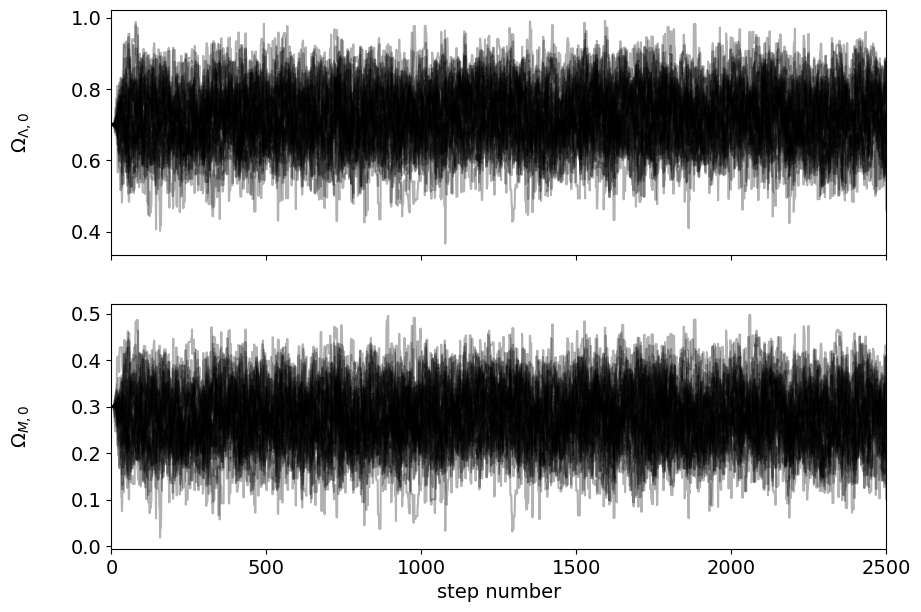

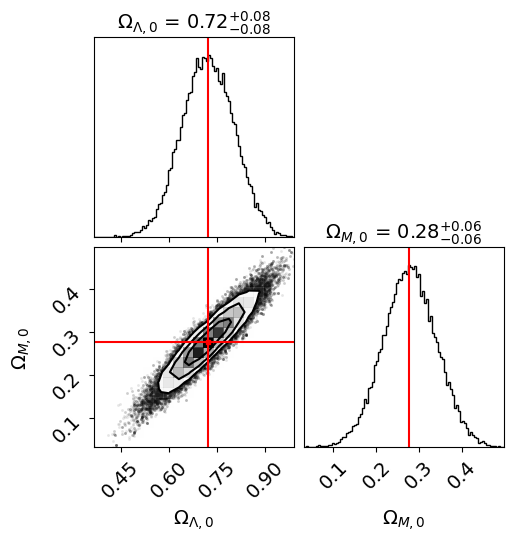

In [68]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = -1))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0 = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3]) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 14})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

wCDM model

100%|██████████| 2500/2500 [1:55:15<00:00,  2.77s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

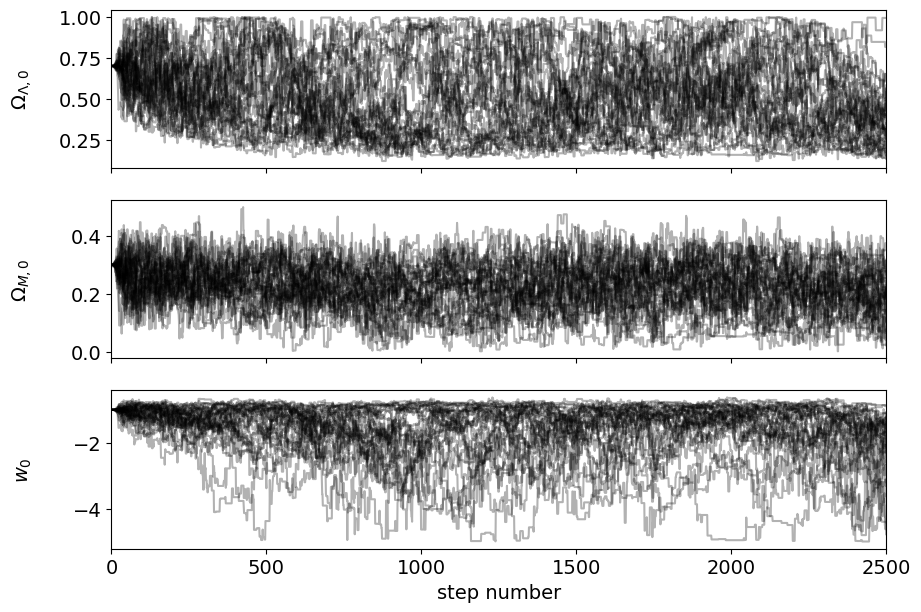

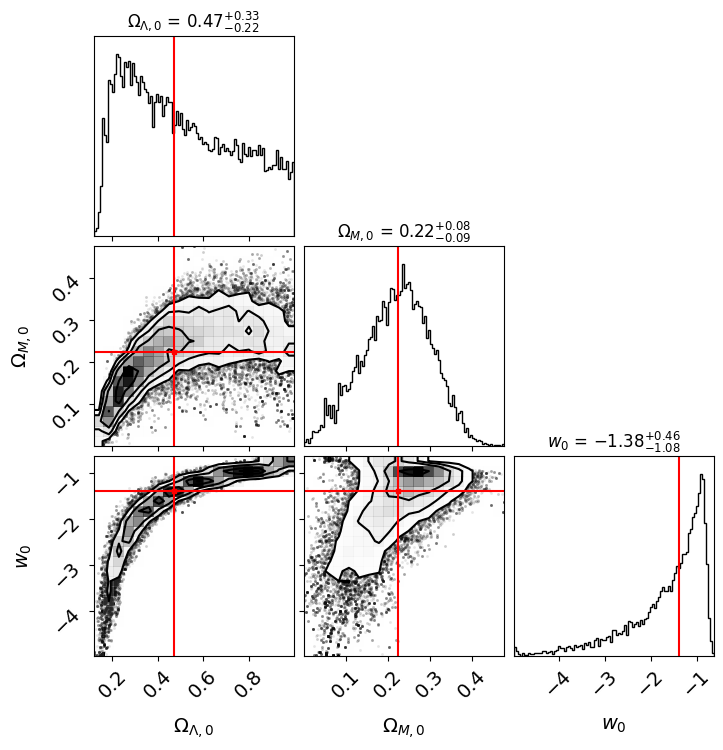

In [69]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0, w_0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = w_0))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0, w_0 = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1 and -5 < w_0 < 0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3, -1]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$', "$w_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1], np.percentile(flat_samples[:, 2], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Asymptotic model: $w(z) = w_0 + w_a\frac{z}{1+z}$

100%|██████████| 2500/2500 [53:42<00:00,  1.29s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

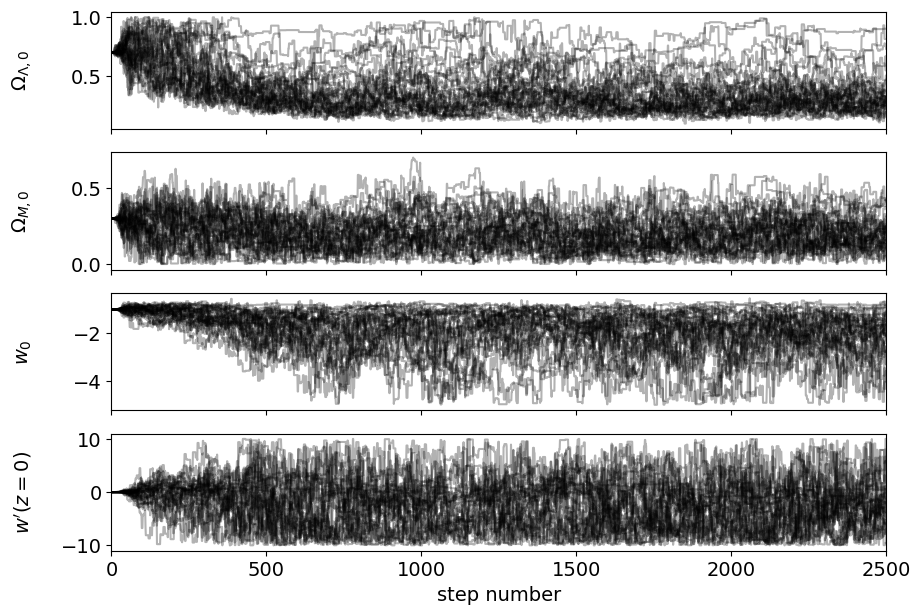

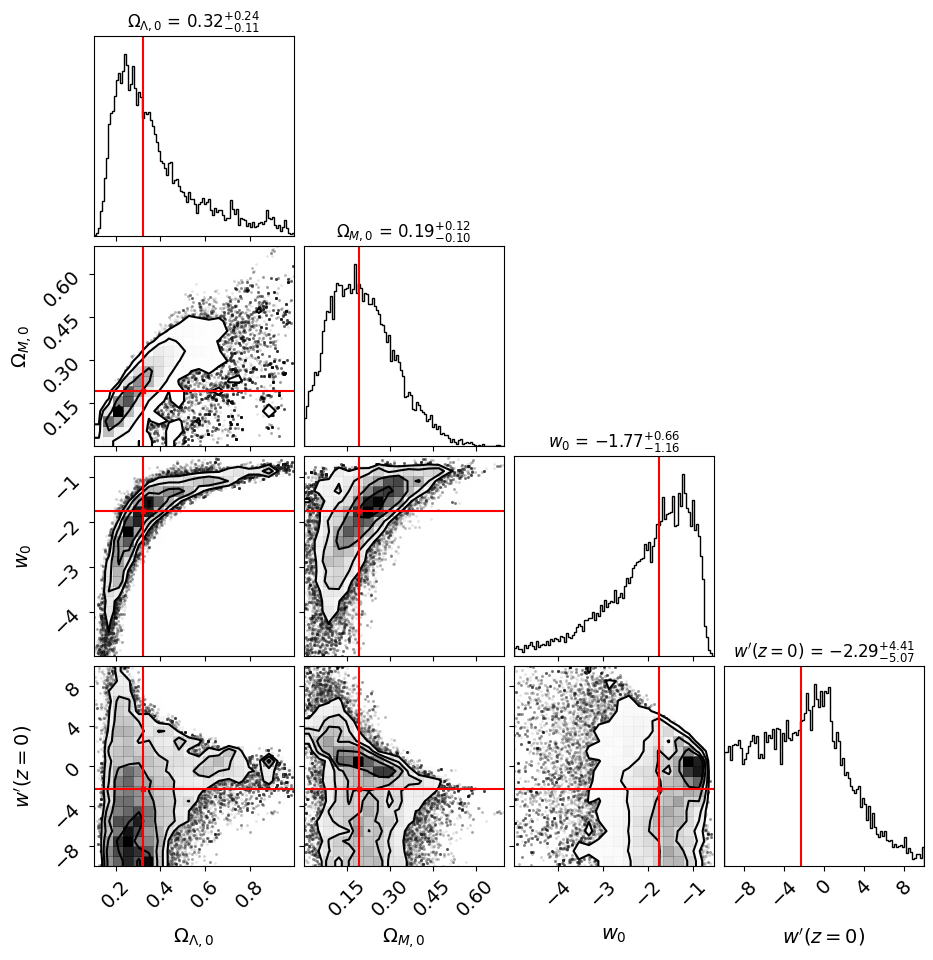

In [70]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = 'asymptotic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1 and -5 < w_0 < 0 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3, -1, 0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1], np.percentile(flat_samples[:, 2], [16, 50, 84])[1], np.percentile(flat_samples[:, 3], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

$w(z) = w_0 + w_{z}z$

100%|██████████| 2500/2500 [54:12<00:00,  1.30s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

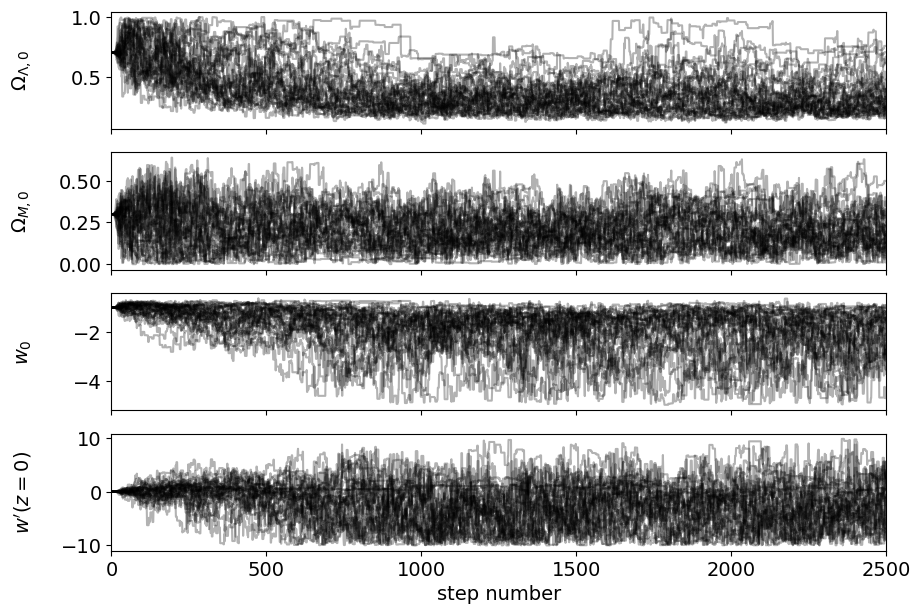

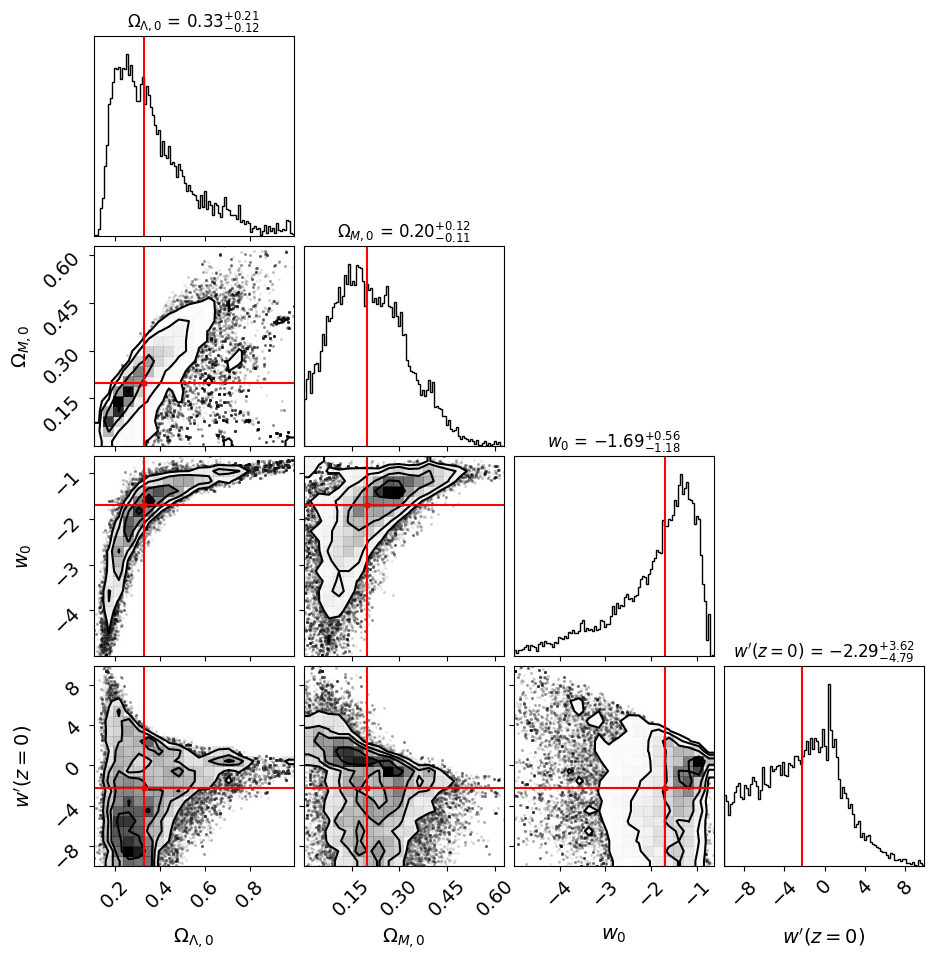

In [71]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = 'linear', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1 and -5 < w_0 < 0 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3, -1, 0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1], np.percentile(flat_samples[:, 2], [16, 50, 84])[1], np.percentile(flat_samples[:, 3], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

$w(z) = w_0 + w_a\ln(1+z)$ - Logarithmic model

100%|██████████| 2500/2500 [1:02:47<00:00,  1.51s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

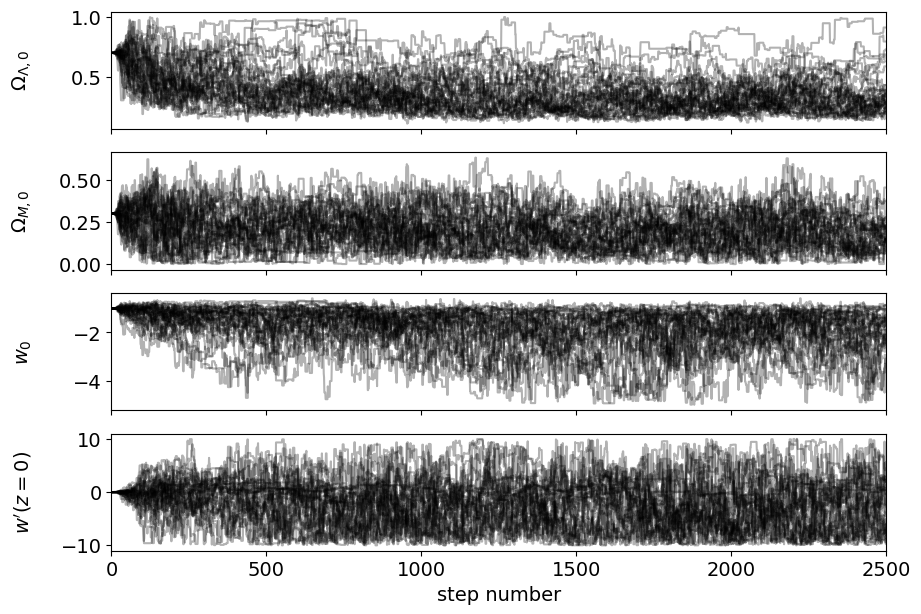

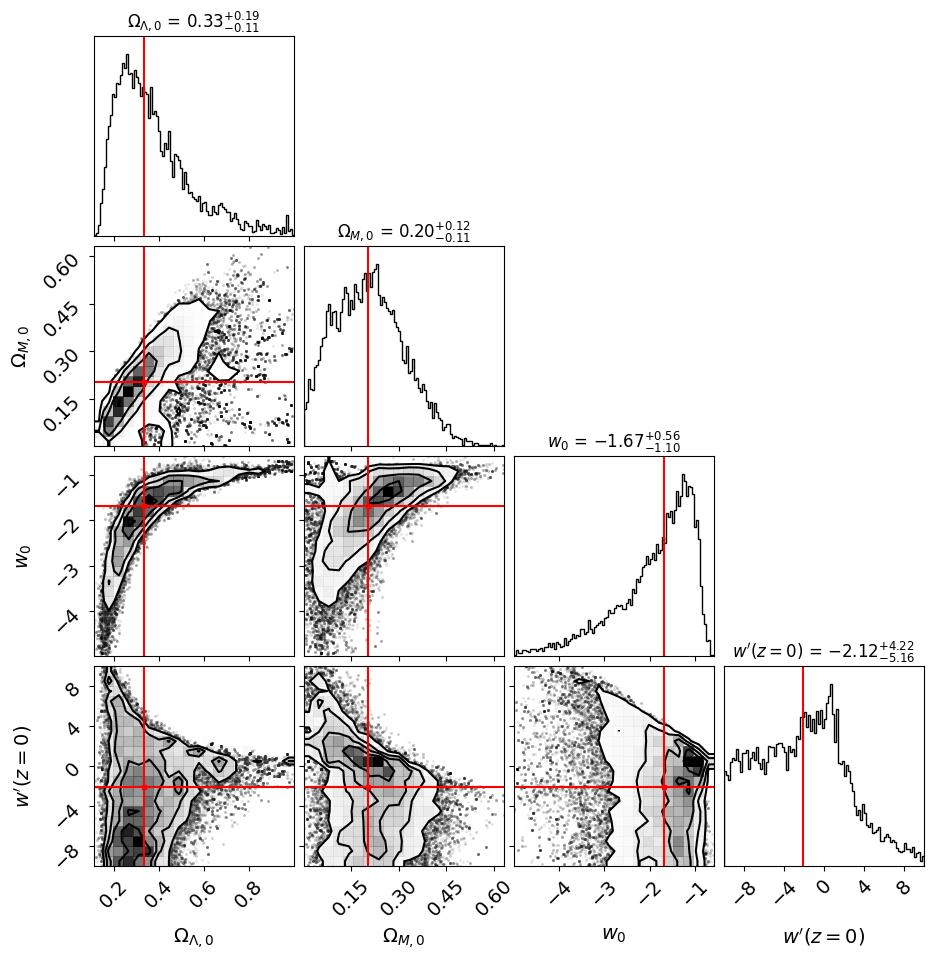

In [72]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = 'logarithmic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1 and -5 < w_0 < 0 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3, -1, 0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1], np.percentile(flat_samples[:, 2], [16, 50, 84])[1], np.percentile(flat_samples[:, 3], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

$w(z) = w_0 + w_a \frac{z}{(1+z)^2}$ - p = 2 model

100%|██████████| 2500/2500 [52:51<00:00,  1.27s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

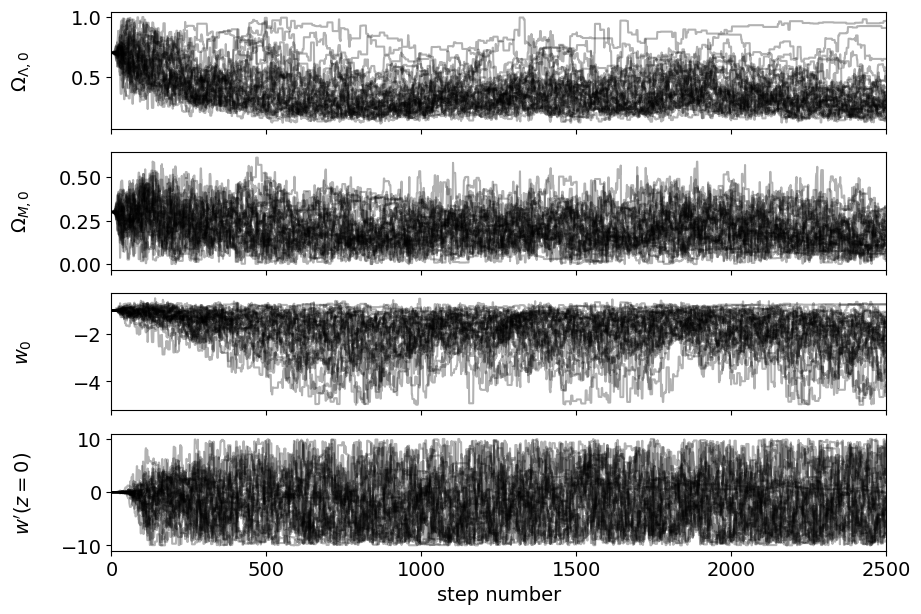

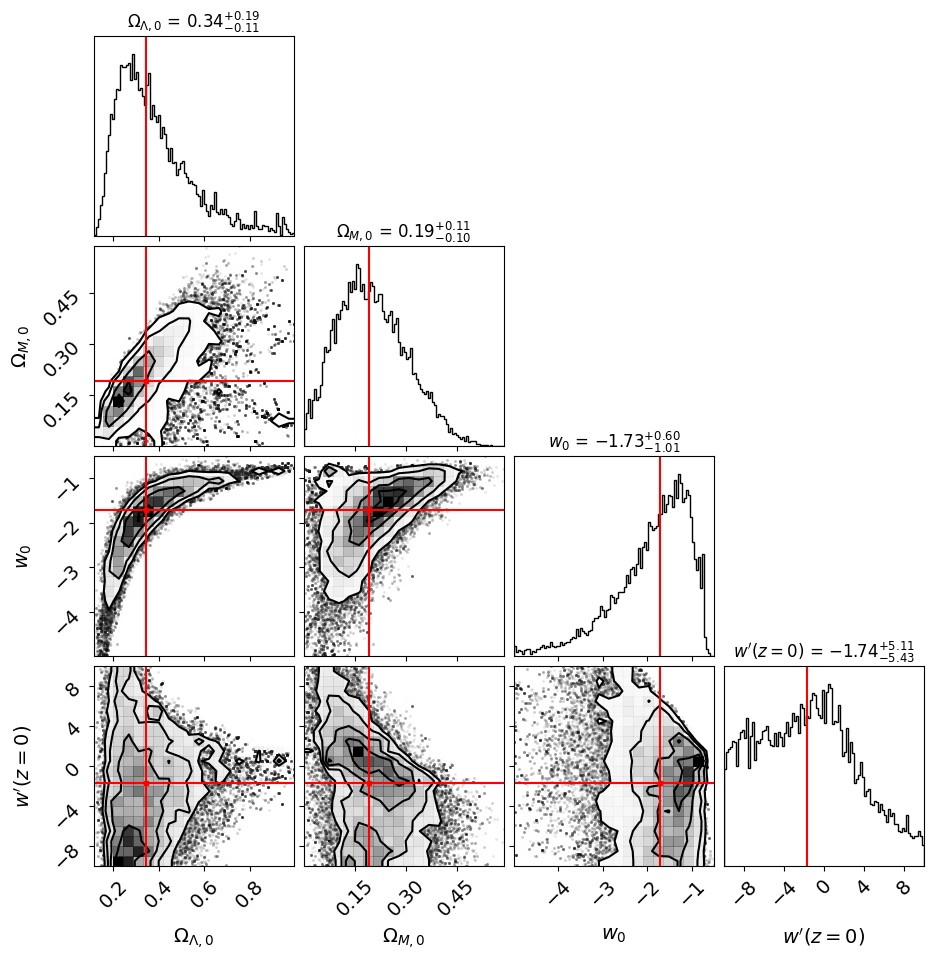

In [73]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = 'p=2', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1 and -5 < w_0 < 0 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3, -1, 0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1], np.percentile(flat_samples[:, 2], [16, 50, 84])[1], np.percentile(flat_samples[:, 3], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

*WITH PRIORS*

$\Lambda CDM$ model

100%|██████████| 2500/2500 [34:33<00:00,  1.21it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

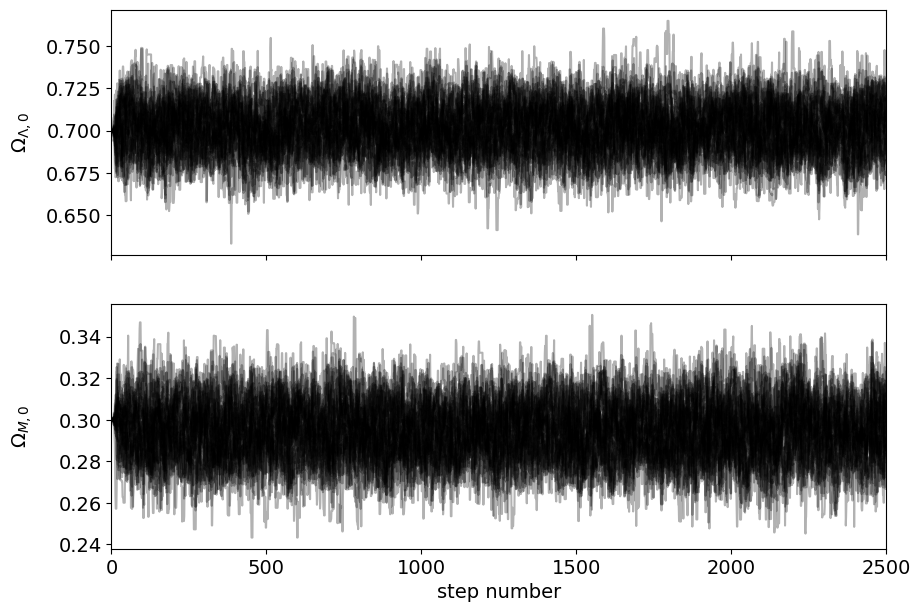

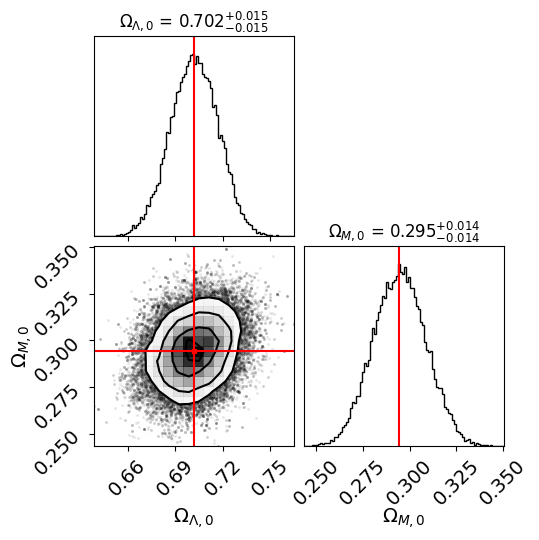

In [6]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = -1))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0 = theta
    if not (0 < omega_lambda0 < 1 and 0 < omega_M0 < 1):
        return -np.inf
    
    # Gaussian prior on omega_lambda0
    lambda_mu = 0.6889     # mean of the Gaussian prior
    lambda_sigma = 3* 0.0056 # standard deviation of the Gaussian prior
    lp1 = -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    # Gaussian prior on omega_M0
    M_mu = 0.3111     # mean of the Gaussian prior
    M_sigma = 3* 0.0056 # standard deviation of the Gaussian prior
    lp2 = -0.5*((omega_M0 - M_mu)/M_sigma)**2

    return lp1+lp2

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3]) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.3f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [7]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

wCDM model

Asymptotic model: $w(z) = w_0 + w_a\frac{z}{1+z}$

100%|██████████| 1000/1000 [25:40<00:00,  1.54s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

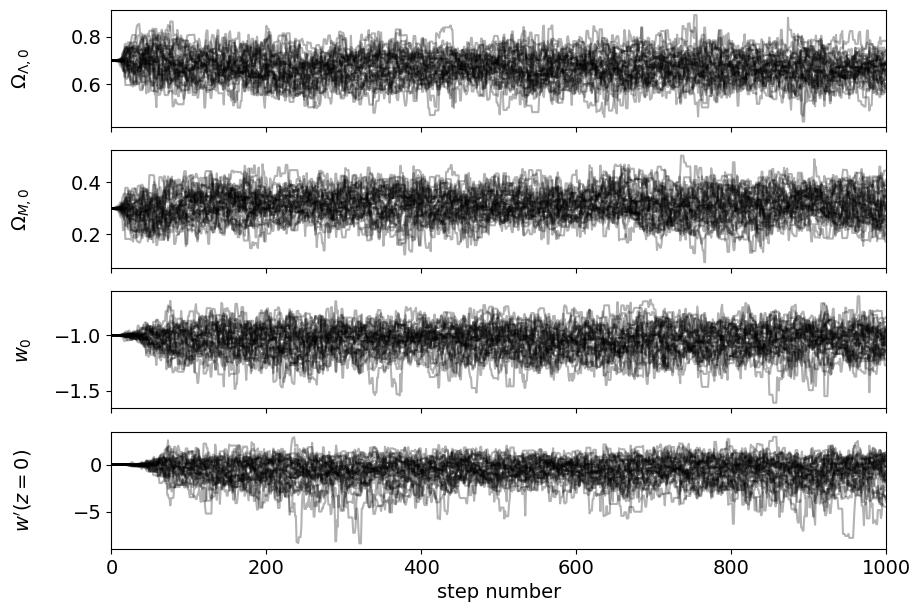

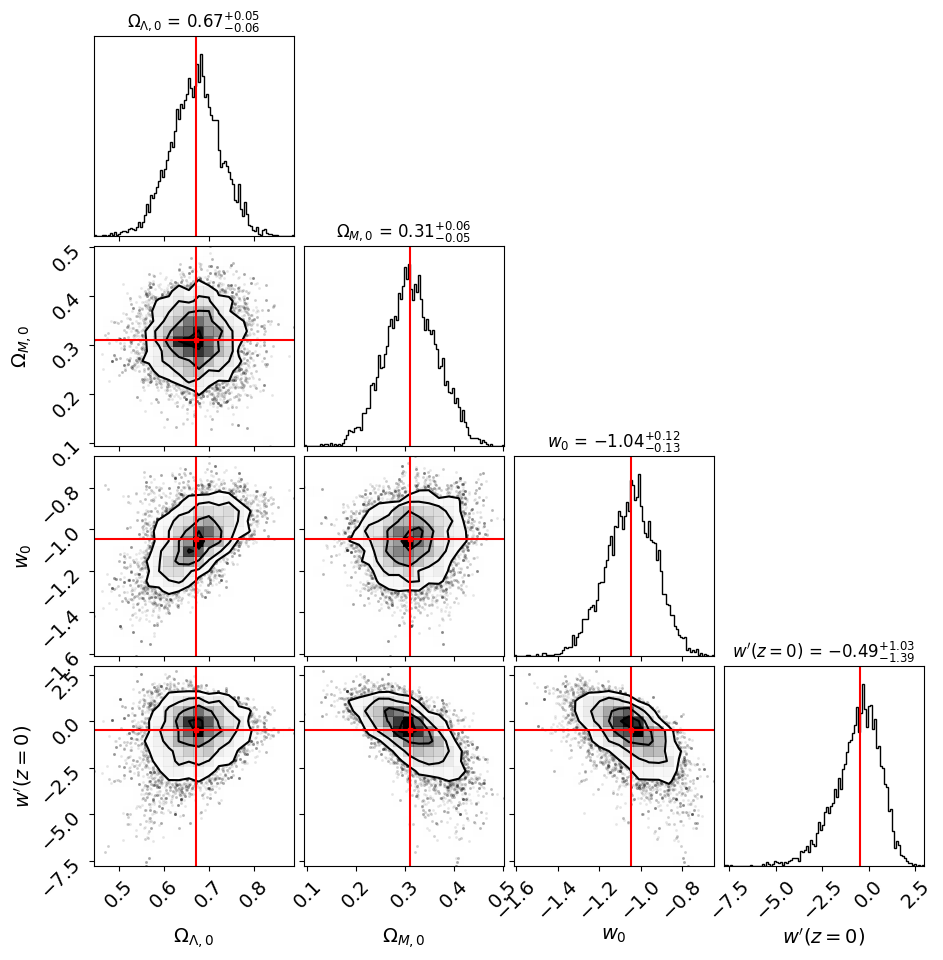

In [76]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = 'asymptotic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0, w_0, w_a = theta
    if not(0 < omega_lambda0 < 1 and 0 < omega_M0 < 1 and -5 < w_0 < 0 and -5 < w_a < 5):
        return -np.inf
    
    lp = 0
    # Gaussian prior on omega_lambda0
    lambda_mu = 0.6889     # mean of the Gaussian prior
    lambda_sigma = 10* 0.0056 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    # Gaussian prior on omega_M0
    M_mu = 0.3111     # mean of the Gaussian prior
    M_sigma = 10* 0.0056 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_M0 - M_mu)/M_sigma)**2

    return lp

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([0.7, 0.3, -1, 0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, 1000, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, 0], [16, 50, 84])[1], np.percentile(flat_samples[:, 1], [16, 50, 84])[1], np.percentile(flat_samples[:, 2], [16, 50, 84])[1], np.percentile(flat_samples[:, 3], [16, 50, 84])[1]],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

$w(z) = w_0 + w_{z}z$

$w(z) = w_0 + w_a\ln(1+z)$ - Logarithmic model

$w(z) = w_0 + w_a \frac{z}{(1+z)^2}$ - p = 2 model